# Udacity Machine Learning PCA mini-project

#### Prep stuff:

In [1]:
from time import time
import pylab as pl
import numpy as np
%pylab inline
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

Populating the interactive namespace from numpy and matplotlib


#### Fetching and loading data:

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
np.random.seed(42)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 966 faces
done in 0.453s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.059s


In [5]:
print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 13.974s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.005, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)


In [6]:
print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.047s
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.82      0.85      0.84        60
  Donald Rumsfeld       0.95      0.74      0.83        27
    George W Bush       0.85      0.97      0.91       146
Gerhard Schroeder       0.95      0.84      0.89        25
      Hugo Chavez       0.92      0.73      0.81        15
       Tony Blair       0.91      0.83      0.87        36

      avg / total       0.87      0.87      0.87       322

[[  6   2   0   5   0   0   0]
 [  1  51   0   7   0   1   0]
 [  0   2  20   4   0   0   1]
 [  0   5   0 141   0   0   0]
 [  0   0   0   3  21   0   1]
 [  0   2   0   1   0  11   1]
 [  0   0   1   4   1   0  30]]


In [7]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

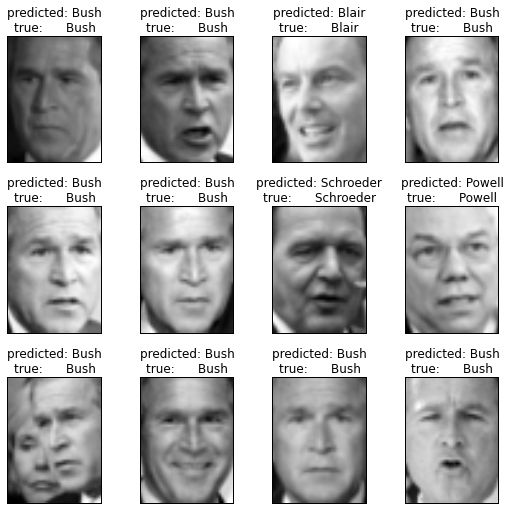

In [8]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

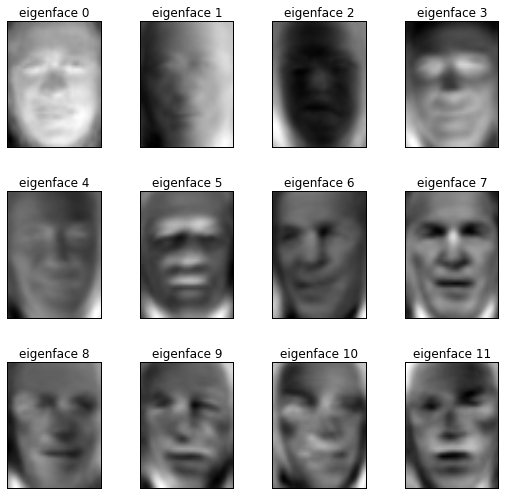

In [9]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [10]:
pca.explained_variance_ratio_[:5]

array([ 0.17929037,  0.15498482,  0.07335587,  0.06154105,  0.05191788])

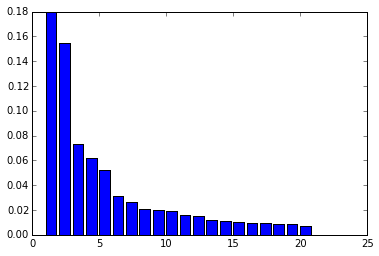

In [11]:
pl.bar(range(1,21),pca.explained_variance_ratio_[:20])
pl.show()

#### Finding a set of PCs that explains ~75% of the variance:

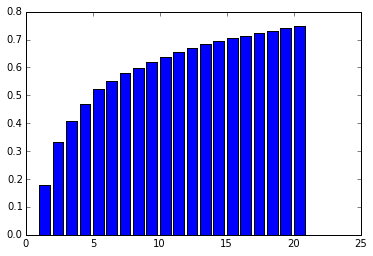

20 components explain ~75% of the variance
73 components explain ~90% of the variance


In [12]:
n75 = len([i for i in pca.explained_variance_ratio_.cumsum() if i <= 0.75])
n90 = len([i for i in pca.explained_variance_ratio_.cumsum() if i <= 0.90])
pl.bar(range(1,21),pca.explained_variance_ratio_.cumsum()[:20])
pl.show()
print "%s components explain ~75%% of the variance" %n75
print "%s components explain ~90%% of the variance" %n90

In [13]:
n_components = n75

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 20 eigenfaces from 966 faces
done in 0.109s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s


In [14]:
print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 7.722s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.005, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)


#### Performance:

In [15]:
print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.011s
                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.31      0.27        13
     Colin Powell       0.66      0.75      0.70        60
  Donald Rumsfeld       0.57      0.59      0.58        27
    George W Bush       0.86      0.82      0.84       146
Gerhard Schroeder       0.60      0.48      0.53        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.58      0.61      0.59        36

      avg / total       0.72      0.70      0.71       322

[[  4   5   1   3   0   0   0]
 [  8  45   0   4   2   0   1]
 [  4   1  16   3   2   0   1]
 [  1  12   9 119   0   1   4]
 [  0   1   1   3  12   0   8]
 [  0   1   0   2   1   9   2]
 [  0   3   1   5   3   2  22]]


#### ~90% explained variance:

In [16]:
n_components = n90

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 73 eigenfaces from 966 faces
done in 0.241s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.033s


In [17]:
print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 6.974s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.01, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)


#### Performance:

In [18]:
print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.029s
                   precision    recall  f1-score   support

     Ariel Sharon       0.77      0.77      0.77        13
     Colin Powell       0.84      0.82      0.83        60
  Donald Rumsfeld       0.83      0.74      0.78        27
    George W Bush       0.86      0.97      0.91       146
Gerhard Schroeder       1.00      0.76      0.86        25
      Hugo Chavez       1.00      0.73      0.85        15
       Tony Blair       0.94      0.81      0.87        36

      avg / total       0.88      0.87      0.87       322

[[ 10   1   1   1   0   0   0]
 [  2  49   0   9   0   0   0]
 [  1   1  20   5   0   0   0]
 [  0   2   1 142   0   0   1]
 [  0   0   2   3  19   0   1]
 [  0   2   0   2   0  11   0]
 [  0   3   0   4   0   0  29]]
